In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/gdrive/ML_Data/FoodReviews')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp drive/MyDrive/ML_Data/FoodReviews/attentionModule.py .

In [4]:
from attentionModule import AttentionLayer

In [5]:
data = pd.read_csv('/content/drive/MyDrive/ML_Data/FoodReviews/Reviews.csv')

In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [8]:
data.shape

(393565, 10)

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
for i in range(4):
    print(data['Text'][i])
    print()
    print(data['Summary'][i])
    print()

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Good Quality Dog Food

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Not as Advertised

This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to th

In [11]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
from bs4 import BeautifulSoup

In [13]:
def preProcessText(text,n):
    s = text.lower()
    s = BeautifulSoup(s,'lxml').text
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub('"','', s)
    s = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in s.split(" ")])
    s = re.sub(r"'s\b","",s)
    s = re.sub("[^a-zA-Z]", " ", s) 
    s = re.sub('[m]{2,}', 'mm', s)
    if(n==0):
        tokens = [w for w in s.split() if not w in stop_words]
    else:
        tokens = s.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [14]:
clean_text = []
for i in data['Text']:
    clean_text.append(preProcessText(i,0))
    
clean_summary = []
for i in data['Summary']:
    clean_summary.append(preProcessText(i,1))

data['clean_text']=clean_text
data['clean_summary']=clean_summary

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

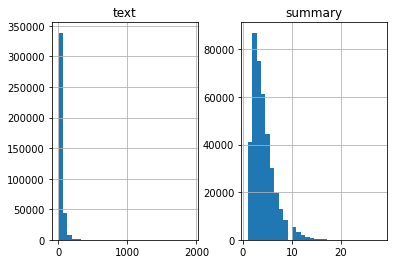

In [16]:
text_count = [len(i.split()) for i in data['clean_text']]
summary_count = [len(i.split()) for i in data['clean_summary']]

length_df = pd.DataFrame({'text':text_count, 'summary':summary_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
cnt=0
for i in data['clean_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['clean_summary']))

0.9458130834941876


In [18]:
# Fixing the max length of summary to 8
max_text_len=30
max_summary_len=8

In [19]:
cleaned_text =np.array(data['clean_text'])
cleaned_summary=np.array(data['clean_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
df.head(3)

,text,summary
0,bought several vitality canned dog food produc...,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts p...,sostok not as advertised eostok
2,looking secret ingredient robitussin believe f...,sostok cough medicine eostok


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = np.array(df['text'])
y = np.array(df['summary'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle=True)

In [24]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

In [25]:
threshold = 4
count=0
tot_count=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(count/tot_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.05287146763902
Total Coverage of rare words: 1.4420807723905116


In [26]:
x_tokenizer = Tokenizer(num_words=tot_count-count) 
x_tokenizer.fit_on_texts(list(X_train))

X_train_seq = x_tokenizer.texts_to_sequences(X_train) 
X_test_seq = x_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train_seq,  maxlen=max_text_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_text_len, padding='post')

x_vocabulary = x_tokenizer.num_words + 1

In [27]:
print('size of x vocabulary: {}'.format(x_vocabulary))

size of x vocabulary: 17524


In [28]:
# Tokenizer for summary
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [29]:
threshold = 8
count=0
tot_count=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(count/tot_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.95390598742017
Total Coverage of rare words: 3.1169699708007985


In [30]:
y_tokenizer = Tokenizer(num_words = tot_count-count)
y_tokenizer.fit_on_texts(list(y_train))

y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

y_vocabulary = y_tokenizer.num_words +1

In [31]:
print('size of y vocabulary: {}'.format(y_vocabulary))

size of y vocabulary: 4176


In [32]:
# Model

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb  = Embedding(x_vocabulary,100,trainable = True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(300,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(300,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(300, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# --------------- ---------------- ------------------- --------------------

# Decoder
decoder_inputs = Input(shape=(None,))
#embedding layer
dec_emb_layer = Embedding(y_vocabulary, 100,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(300, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenation of attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1752400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [35]:
history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
1504/1504 [==============================] - 593s 387ms/step - loss: 2.9128 - val_loss: 2.3857
Epoch 2/50
1504/1504 [==============================] - 586s 389ms/step - loss: 2.3500 - val_loss: 2.2333
Epoch 3/50
1504/1504 [==============================] - 591s 393ms/step - loss: 2.2172 - val_loss: 2.1455
Epoch 4/50
1504/1504 [==============================] - 601s 399ms/step - loss: 2.1460 - val_loss: 2.1067
Epoch 5/50
1504/1504 [==============================] - 591s 393ms/step - loss: 2.0951 - val_loss: 2.0633
Epoch 6/50
1504/1504 [==============================] - 589s 392ms/step - loss: 2.0508 - val_loss: 2.0393
Epoch 7/50
1504/1504 [==============================] - 592s 393ms/step - loss: 2.0227 - val_loss: 2.0251
Epoch 8/50
1504/1504 [==============================] - 592s 394ms/step - loss: 2.0020 - val_loss: 2.0053
Epoch 9/50
1504/1504 [==============================] - 587s 390ms/step - loss: 1.9846 - val_loss: 2.0073
Epoch 10/50
1504/1504 [=======================

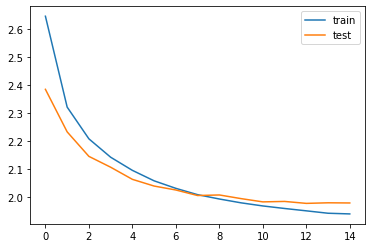

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [38]:
reverse_target_word_index

{1: 'sostok',
 2: 'eostok',
 3: 'great',
 4: 'good',
 5: 'the',
 6: 'best',
 7: 'not',
 8: 'for',
 9: 'love',
 10: 'and',
 11: 'it',
 12: 'coffee',
 13: 'tea',
 14: 'product',
 15: 'my',
 16: 'delicious',
 17: 'this',
 18: 'is',
 19: 'very',
 20: 'taste',
 21: 'but',
 22: 'excellent',
 23: 'yummy',
 24: 'to',
 25: 'of',
 26: 'price',
 27: 'flavor',
 28: 'these',
 29: 'tasty',
 30: 'ever',
 31: 'like',
 32: 'in',
 33: 'stuff',
 34: 'favorite',
 35: 'dog',
 36: 'too',
 37: 'yum',
 38: 'so',
 39: 'awesome',
 40: 'as',
 41: 'food',
 42: 'snack',
 43: 'free',
 44: 'loves',
 45: 'just',
 46: 'are',
 47: 'chocolate',
 48: 'with',
 49: 'wonderful',
 50: 'you',
 51: 'nice',
 52: 'on',
 53: 'perfect',
 54: 'healthy',
 55: 'what',
 56: 'better',
 57: 'no',
 58: 'them',
 59: 'have',
 60: 'tastes',
 61: 'quality',
 62: 'sweet',
 63: 'tasting',
 64: 'dogs',
 65: 'really',
 66: 'hot',
 67: 'than',
 68: 'buy',
 69: 'candy',
 70: 'at',
 71: 'treat',
 72: 'mix',
 73: 'amazing',
 74: 'sugar',
 75: 'glute

In [39]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(300,))
decoder_state_input_c = Input(shape=(300,))
decoder_hidden_state_input = Input(shape=(max_text_len,300))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [40]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [45]:
for i in range(0,25):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: use plain foods mix bit hoisin sauce sweet hot dipping sauce great eggrolls spring rolls whatever love stuff 
Original summary: could not live without it 
Predicted summary:  sauce


Review: every morning used puke mostly much could lead crohn disease spoon wedderspoon every morning wake want puke lot less diarrhea 
Original summary: of wedderspoon 
Predicted summary:  not what expected


Review: family lucky enough get product several years ago friend daughter eat pancake mix everyone fix thinks outstanding 
Original summary: best pancakes ever 
Predicted summary:  pancake mix


Review: good peru coffee good would buy good taste packaged small packages way open much time 
Original summary: coffee review 
Predicted summary:  good coffee


Review: popchips great alternative need munchie crunchie snack much lower calories fat regular chips portioned controlled especially like barbeque flavor salt pepper flavored popchips 
Original summary: popchips 
Predicted summary:  great snac